In [1]:
# %%
import ot
import numpy as np
import otmol as otm
import pandas as pd
from openbabel import pybel
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import os
# %matplotlib widget

In [5]:
def RMSD(V, W):
    """ 
    Calculate Root-mean-square deviation from two sets of vectors V and W.
    """
    N = V.shape[0]
    return np.sqrt(np.sum((V-W)**2)/N)

def compare_lists(list1, list2):
    """
    Compare two lists and return the indices and elements where they differ.

    Args:
        list1 (list): The first list to compare.
        list2 (list): The second list to compare.

    Returns:
        list: A list of tuples, where each tuple contains the index and the differing elements
              in the format (index, element_from_list1, element_from_list2).
    """
    differences = []
    # Compare elements up to the length of the shorter list
    for i in range(len(list1)):
        if list1[i] != list2[i]:
            differences.append((i, list1[i], list2[i]))

    return differences

def parse_molecule_pairs(file_path, mol_type: str = 'water cluster'):
    """
    Parses a file containing molecule pairs separated by an underscore ('_').

    Parameters:
    ----------
    file_path : str
        Path to the file containing molecule pairs.

    Returns:
    -------
    list of lists
        A list where each element is a pair [molA, molB].
    """
    molecule_pairs = []
    with open(file_path, 'r') as file:
        if mol_type == 'water cluster' or mol_type == 'S1':
            for line in file:
                line = line.strip()  # Remove any leading/trailing whitespace
                if line:  # Skip empty lines
                    # Some lines are like "molA_molB_2", and some are like "molA_molB"
                    molecule_pairs.append([line.split('_')[0], line.split('_')[1]])
        if mol_type == 'FGG':
            next(file)  # Skip the first line
            for line in file:
                line = line.strip()
                if line:
                    molA, molB = line.split('-')
                    molecule_pairs.append([molA, molB])
    return molecule_pairs

def parse_and_permute_xyz(xyz_file, permutation):
    """
    Parse an XYZ file, permute the water molecules, and return a list of coordinates
    with O atoms always listed before H atoms in each water molecule.

    Args:
        xyz_file (str): Path to the input XYZ file.
        permutation (list): A list of integers representing the new order of water molecules.

    Returns:
        list: A list of coordinates for the permuted water molecules.
    """
    with open(xyz_file, 'r') as file:
        lines = file.readlines()

    # Read the number of atoms and the comment line
    num_atoms = int(lines[0].strip())
    comment = lines[1].strip()

    # Ensure the number of atoms is divisible by 3 (for water molecules)
    if num_atoms % 3 != 0:
        raise ValueError("The number of atoms in the XYZ file is not divisible by 3.")

    # Group atoms into water molecules (3 atoms per molecule)
    molecules = [lines[i:i+3] for i in range(2, len(lines), 3)]

    # Reorder the molecules based on the permutation
    permuted_molecules = [molecules[i] for i in permutation]

    # Ensure O atom is listed before H atoms in each molecule
    sorted_molecules = []
    for molecule in permuted_molecules:
        # Sort the atoms in the molecule: O first, then H
        sorted_molecule = sorted(molecule, key=lambda line: line.split()[0] == 'H')
        sorted_molecules.append(sorted_molecule)

    # Extract coordinates from the sorted and permuted molecules
    coordinates = []
    for molecule in sorted_molecules:
        for atom_line in molecule:
            parts = atom_line.split()
            coordinates.append([float(parts[1]), float(parts[2]), float(parts[3])])

    return np.array(coordinates, dtype=float)

def initialize_block_matrix(N, K):
    """
    Initialize a 3N x 3N block matrix with diagonal blocks of [[0, K, K], [K, 0, 0], [K, 0, 0]].

    Args:
        N (int): Number of diagonal blocks (equal to X_A.shape[0]).
        K (float): A large number to fill the blocks.

    Returns:
        np.ndarray: The initialized 3N x 3N block matrix.
    """
    # Create a single diagonal block
    block = np.array([[0, K, K],
                      [K, 0, 0],
                      [K, 0, 0]])

    # Initialize the full 3N x 3N matrix with zeros
    matrix = np.ones((3 * N, 3 * N))*K

    # Fill the diagonal blocks
    for i in range(N):
        matrix[3 * i:3 * i + 3, 3 * i:3 * i + 3] = block
    return matrix

def oxygenOT(molA, molB):
    """
    Calculate the optimal transport between oxygen using Gromov-Wasserstein distance.
    """
    X_A, T_A, B_A = otm.tl.process_molecule(molA) # Output (1) spatial coordinates, (2) atom types, and (3) bonds as numpy arrays.
    X_B, T_B, B_B = otm.tl.process_molecule(molB)
    #otm.pl.plot_molecule(X_A, T_A, B_A, coloring = 'type', sizing = 'type')
    #otm.pl.plot_molecule(X_B, T_B, B_B, coloring = 'type', sizing = 'type')
    #print(compare_lists(T_A, T_B[np.argmax(P, axis=1)]))
    #otm.pl.plot_alignment(X_A, B_A, B_B, P, weight_cutoff=0.01)
    #plt.show()
    T_A, T_B = np.array(T_A, dtype=str), np.array(T_B, dtype=str)
    O_A, O_B = X_A[T_A == 'O'], X_B[T_B == 'O']
    rmsd_best = 1e10
    #    p_best = None
    PO_best = None
    #R_best = None
    #t_best = None
    for p in [2,3,4,5,6,7,8]:
        D_A = distance_matrix(X_A[T_A == 'O'], X_A[T_A == 'O'])**p
        D_B = distance_matrix(X_B[T_B == 'O'], X_B[T_B == 'O'])**p
        P_ot = ot.gromov.gromov_wasserstein(D_A/D_A.max(), D_B/D_B.max())
        O_B_aligned = otm.tl.molecule_alignment_allow_reflection(O_A, O_B, P_ot)
        rmsd_ot = RMSD(O_A, O_B_aligned[np.argmax(P_ot, axis=1)])
        #P_ot = ot.emd(np.ones([O_A.shape[0]])/O_A.shape[0], np.ones([O_B.shape[0]])/O_B.shape[0], distance_matrix(O_A, O_B_aligned)**2)
        #O_B_aligned = otm.tl.molecule_alignment_allow_reflection(O_A, O_B, P_ot)
        #rmsd_ot = RMSD(O_A, O_B_aligned[np.argmax(P, axis=1)])
        if rmsd_ot < rmsd_best:
            rmsd_best = rmsd_ot
            #p_best = p
            PO_best = P_ot
            #R_best = R
            #t_best = t
    #print('RMSD:', rmsd_best)
    #print(len(np.unique(np.argmax(PO_best, axis=1))) == O_A.shape[0])
    #otm.pl.plot_alignment(O_A, O_B_aligned, np.zeros((O_A.shape[0], O_A.shape[0])), np.zeros((O_B.shape[0], O_B.shape[0])), PO_best, weight_cutoff=0.01)
    #plt.show()
    return PO_best #R_best, t_best

In [3]:
def Experiment(data_path: str = None,mol_pair: list = None, method: str = 'fgw', 
               alpha_list: list = None, D_matrix: str = 'geodesic', p_list: list = None,
               ):
    """
    Experiment with ArbAlign data.
    """
    results = []
    # Load the molecule pairs from the specified file
    for nameA, nameB in mol_pair:
        molA = next(pybel.readfile('xyz', os.path.join(data_path, nameA + '.xyz')))
        molB = next(pybel.readfile('xyz', os.path.join(data_path, nameB + '.xyz')))
        # Basic processing of the molecules
        PO_best = oxygenOT(molA, molB)
        X_A = parse_and_permute_xyz(os.path.join(data_path, nameA + '.xyz'), np.arange(PO_best.shape[0])) # just order atoms inside a water molecule
        X_B = parse_and_permute_xyz(os.path.join(data_path, nameB + '.xyz'), np.argmax(PO_best, axis=1)) 
        T_A, T_B = np.array(['O', 'H', 'H']*int(X_A.shape[0]/3), dtype=str), np.array(['O', 'H', 'H']*int(X_B.shape[0]/3), dtype=str)
        C = initialize_block_matrix(int(X_A.shape[0]/3), 1e6)
        D_A = distance_matrix(X_A, X_A)
        D_B = distance_matrix(X_B, X_B)
        rmsd_best = 1e10
        p_best = None
        P_best = None
        alpha_best = None
        if method == 'fgw':
        # Fused Gromov-Wasserstein
            for alpha in alpha_list:
                for p in p_list:
                    if D_matrix == 'euclidean':
                        P = otm.tl.molecule_optimal_transport(C, D_A**p, D_B**p, method=method, alpha=alpha)
                    X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P)
                    rmsd = RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)])
                    if rmsd < rmsd_best:
                        rmsd_best = rmsd
                        p_best = p
                        P_best = P
                        alpha_best = alpha
            optimal_assignment = np.argmax(P_best, axis=1)

        if len(np.unique(optimal_assignment)) != X_A.shape[0]: # check if the assignment is 1 to 1
            print(nameA, nameB, 'Warning: the assignment is not 1 to 1')
        if compare_lists(T_A, T_B[optimal_assignment]): # check if atom names are matched. We have matched T_B with T_A by parse_and_permute_xyz()
            print(nameA, nameB, 'Warning: unmatched atom names exist')
        results.append({
            'nameA': nameA,
            'nameB': nameB,
            'RMSD({}+{})'.format(method, D_matrix): rmsd_best,
            '# atoms': X_A.shape[0],
            'alpha': alpha_best,
            'p': p_best,
            'assignment': optimal_assignment,
            'atomname_diff': compare_lists(T_A, T_B[optimal_assignment])
        }) 
        print(nameA, nameB, rmsd_best)

    return pd.DataFrame(results)

In [6]:
data_path = "./DataArbAlign/Water-Clusters"
#data_path = "./DataArbAlign/FGG"
mol_pair_list_path = os.path.join(data_path, 'list')
molecule_pairs = parse_molecule_pairs(mol_pair_list_path, mol_type='water cluster')
otmol_res = Experiment(data_path, molecule_pairs, method='fgw', D_matrix='euclidean', alpha_list=np.linspace(0,0.1,100), p_list=[1])
#print(otmol_res)

2-Cs-1 2-OpenC1 0.8127225849122315
3-UUD 3-UUU 0.30959488017447045
4-Ci 4-S4 1.3397035777765256
5-CA-A 5-CA-B 1.0640064657688393
6-BAG 6-BK-1 1.5406700959975914
7-BI1 7-BI2 0.45042508725308283
8-D2d 8-S4 0.6076111551042118
9-D2dDD 9-S4DA 0.6406989561890261
10-PP1 10-PP2 0.6384402177196827
11-551A-1 11-551A-4 0.1368886733789567
12-D2d-1-L 12-D2d-1-R 2.0895479776990027
13-TIP4P 13-TIP5P 1.342199096425271
14-1 14-2 0.5519288333105364
15-1 15-2 1.2115372691880333
16-TIP4P 16-TIP5P 1.6113414322390318
17-TIP4P 17-TIP5P 1.2332410886442404
18-TIP4P 18-TIP5P 1.6955760393168564
19-TIP4P 19-TIP5P 2.016496293909357
20-TIP4P 20-TIP5P 1.9428235823833453
21-TIP4P 21-TIP5P 1.9926387452681282
25-1 25-2 1.258447860121683
40-a 40-b 2.6646069892213435
60-1 60-2 2.363057569003632
100-1 100-2 2.3429493600623448


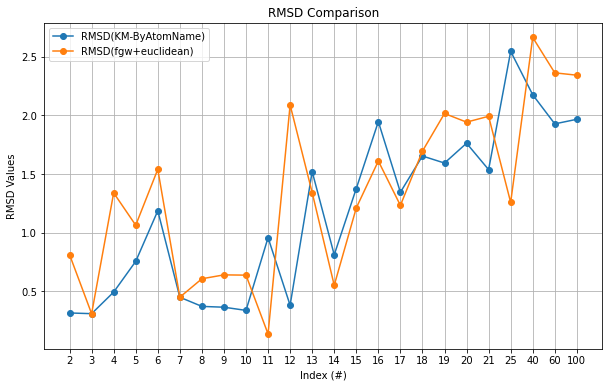

In [7]:
# Concatenate otmol_res and df along the columns
arbalign_res = pd.read_csv(os.path.join(data_path, 'rmsd-2017.dat'), sep='\s+')

combined_df = pd.concat([otmol_res, arbalign_res], axis=1)

# Plot the specified columns against the uniform index
columns_to_plot = ["RMSD(KM-ByAtomName)", "RMSD(fgw+euclidean)"]

plt.figure(figsize=(10, 6))
# Plot each column against the uniform index
for column in columns_to_plot:
    plt.plot(range(len(combined_df['#'])), combined_df[column], marker='o', label=column)

# Update the x-axis ticks to show the actual values in the '#' column
plt.xticks(range(len(combined_df['#'])), combined_df['#'])

plt.title("RMSD Comparison")
plt.xlabel("Index (#)")  # Reflect the '#' column in the label
plt.ylabel("RMSD Values")
plt.legend()
plt.grid(True)

In [13]:
def molecule_alignment_allow_reflection2(
    X1: np.ndarray,
    X2: np.ndarray,
    P: np.ndarray
):
    """
    Perform rigid body rotation, reflection, and translation to align the second point cloud onto the first point cloud guided by an OT plan.

    Parameters
    ----------
    X1
        The 3D coordinates of molecule 1 (template) as an ``n`` x ``3`` array.
    X2
        The 3D coordinates of molecule 2 (to be aligned) as an ``m`` x ``3`` array.
    P
        The ``n`` x ``m`` optimal transport plan describing the correspondence between the molecules.

    Returns
    -------
    X2_aligned : np.ndarray
        The ``m`` x ``3`` coordinates matrix of the aligned molecule 2.
    """

    total_weight = P.sum()
    
    # Compute weights for each point
    w1 = P.sum(axis=1)  # weights for X1
    w2 = P.sum(axis=0)  # weights for X2
    
    # Compute weighted centroids
    mu1 = np.sum(X1 * w1[:, None], axis=0) / total_weight
    mu2 = np.sum(X2 * w2[:, None], axis=0) / total_weight
    
    # Center the point clouds
    X1_centered = X1 - mu1
    X2_centered = X2 - mu2
    
    # Compute weighted cross-covariance matrix
    #d = X1.shape[1]  # should be 3
    #H = np.zeros((d, d))
    #n, m = P.shape
    #for i in range(n):
    #    for j in range(m):
    #        H += P[i, j] * np.outer(X1_centered[i], X2_centered[j])

    # vectorized calculation: H = X1_centered^T P X2_centered 
    H = X1_centered.T @ P @ X2_centered
    
    # Compute SVD of H
    U, _, Vt = np.linalg.svd(H)
    
    # Allow reflection by not enforcing det(R)==1
    R = U @ Vt
    
    # Compute the translation
    t = mu1 - R @ mu2
    
    # Transform X2
    X2_aligned = (R @ X2.T).T + t
    
    return X2_aligned, R, t

In [10]:
# %%
# Read the molecules
molA = next(pybel.readfile("xyz", "./DataArbAlign/Water-Clusters/2-Cs-1.xyz"))
molB = next(pybel.readfile("xyz", "./DataArbAlign/Water-CLusters/2-OpenC1.xyz"))
#molA = next(pybel.readfile("xyz", "./DataArbAlign/S1-MA-W1/s1maw1-1.xyz"))

In [11]:
# Basic processing of the molecules
X_A, T_A, B_A = otm.tl.process_molecule(molA) # Output (1) spatial coordinates, (2) atom types, and (3) bonds as numpy arrays.
X_B, T_B, B_B = otm.tl.process_molecule(molB)

In [ ]:
def permute_3N_matrix(matrix, permutation):
    """
    Permute consecutive 3-row groups of a 3N x 3 matrix based on a given permutation.

    Args:
        matrix (numpy.ndarray): A 3N x 3 matrix.
        permutation (list): A list of integers representing the permutation of groups.

    Returns:
        numpy.ndarray: The permuted 3N x 3 matrix.
    """
    N = len(permutation)
    if matrix.shape[0] != 3 * N or matrix.shape[1] != 3:
        raise ValueError("The input matrix must have dimensions 3N x 3.")
    
    # Split the matrix into N groups of 3 rows
    groups = [matrix[i*3:(i+1)*3] for i in range(N)]
    
    # Rearrange the groups based on the permutation
    permuted_groups = [groups[i] for i in permutation]
    
    # Combine the permuted groups back into a single matrix
    permuted_matrix = np.vstack(permuted_groups)
    
    return permuted_matrix
# Compute the distance matrices
D_A = distance_matrix(X_A, X_A)
D_B = distance_matrix(X_B, X_B)
def _oxygenOT(molA, molB):
    """
    Calculate the optimal transport between oxygen using Gromov-Wasserstein distance.
    """
    X_A, T_A, B_A = otm.tl.process_molecule(molA) # Output (1) spatial coordinates, (2) atom types, and (3) bonds as numpy arrays.
    X_B, T_B, B_B = otm.tl.process_molecule(molB)
    rand_p = np.array([1,0], dtype = int)
    X_B = permute_3N_matrix(X_B, rand_p)
    print('X_A:', X_A)
    print('X_B:', X_B)
    #otm.pl.plot_molecule(X_A, T_A, B_A, coloring = 'type', sizing = 'type')
    #otm.pl.plot_molecule(X_B, T_B, B_B, coloring = 'type', sizing = 'type')
    #print(compare_lists(T_A, T_B[np.argmax(P, axis=1)]))
    #otm.pl.plot_alignment(X_A, B_A, B_B, P, weight_cutoff=0.01)
    #plt.show()
    T_A, T_B = np.array(T_A, dtype=str), np.array(T_B, dtype=str)
    O_A, O_B = X_A[T_A == 'O'], X_B[T_B == 'O']
    rmsd_best = 1e10
    #    p_best = None
    PO_best = None
    R_best = None
    t_best = None
    for p in [2]:
        D_A = distance_matrix(X_A[T_A == 'O'], X_A[T_A == 'O'])**p
        D_B = distance_matrix(X_B[T_B == 'O'], X_B[T_B == 'O'])**p
        P = ot.gromov.gromov_wasserstein(D_A/D_A.max(), D_B/D_B.max())
        O_B_aligned = otm.tl.molecule_alignment_allow_reflection(O_A, O_B, P)
        rmsd_gw = RMSD(O_A, O_B_aligned[np.argmax(P, axis=1)])
        print('RMSD:', rmsd_gw)
        P_ot = ot.emd(np.ones([O_A.shape[0]])/O_A.shape[0], np.ones([O_B.shape[0]])/O_B.shape[0], distance_matrix(O_A, O_B_aligned)**2)
        O_B_aligned, R, t = molecule_alignment_allow_reflection2(O_A, O_B, P_ot)
        print(O_A)
        print(O_B_aligned)
        rmsd_ot = RMSD(O_A, O_B_aligned[np.argmax(P, axis=1)])
        if rmsd_ot < rmsd_best:
            rmsd_best = rmsd_ot
            #p_best = p
            PO_best = P_ot
            R_best = R
            t_best = t
    print('RMSD:', rmsd_best)
    print(len(np.unique(np.argmax(PO_best, axis=1))) == O_A.shape[0])
    #otm.pl.plot_alignment(O_A, O_B_aligned, np.zeros((O_A.shape[0], O_A.shape[0])), np.zeros((O_B.shape[0], O_B.shape[0])), PO_best, weight_cutoff=0.01)
    #plt.show()
    #print(np.argmax(PO_best, axis=1))
    return rand_p[np.argmax(PO_best, axis=1)], R_best, t_best
PO_best, R, t = _oxygenOT(molA, molB)
PO_best

X_A: [[-1.62893 -0.04138  0.37137]
 [-0.69803 -0.09168  0.09337]
 [-2.06663 -0.73498 -0.13663]
 [ 1.21457  0.03172 -0.27623]
 [ 1.72977 -0.08038  0.53387]
 [ 1.44927  0.91672 -0.58573]]
X_B: [[-1.506221 -0.052585 -0.017807]
 [-1.854559  0.760807  0.349291]
 [-0.552517  0.087331 -0.051653]
 [ 1.418065  0.004143 -0.037106]
 [ 1.721983 -0.75696   0.461815]
 [ 2.084191  0.677615  0.112043]]
RMSD: 0.0038357174955800637
[[-1.62893 -0.04138  0.37137]
 [ 1.21457  0.03172 -0.27623]]
[[ 1.21830878  0.03181612 -0.2770815 ]
 [-1.63266878 -0.04147612  0.3722215 ]]
RMSD: 0.0038357174955800637
True


array([1, 0])

In [48]:
X_A = parse_and_permute_xyz(os.path.join(data_path, '2-Cs-1' + '.xyz'), np.arange(PO_best.shape[0])) # just order atoms inside a water molecule
X_B = parse_and_permute_xyz(os.path.join(data_path, '2-OpenC1' + '.xyz'), np.argmax(PO_best, axis=1)) 
C = initialize_block_matrix(int(X_A.shape[0]/3), 1e6)
print(X_A)
print((R @ X_B.T).T + t)
#otm.pl.plot_alignment(X_A, (R @ X_B.T).T + t, ['O', 'H', 'H']*2, ['O', 'H', 'H']*2, PO_best, weight_cutoff=0.01)
#plt.show()

[[-1.62893 -0.04138  0.37137]
 [-0.69803 -0.09168  0.09337]
 [-2.06663 -0.73498 -0.13663]
 [ 1.21457  0.03172 -0.27623]
 [ 1.72977 -0.08038  0.53387]
 [ 1.44927  0.91672 -0.58573]]
[[-1.63266878 -0.04147612  0.3722215 ]
 [-1.73861914  0.35549186  1.23926073]
 [-2.44071956  0.17394031 -0.09701564]
 [ 1.21830878  0.03181612 -0.2770815 ]
 [ 1.36254458  0.50158408 -1.09940804]
 [ 0.25885047 -0.00477762 -0.18557188]]


In [50]:
rmsd_best = 1e10
p_best = None
P_best = None
alpha_best = None
p_list = [0.5, 1, 2, 3]
alpha_list = np.linspace(0,0.1,100)
X_B_aligned_best = None
for alpha in alpha_list:
    for p in p_list:
        P = otm.tl.molecule_optimal_transport(C, D_A**p, D_B**p, method='fgw', alpha=alpha)
        X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P)
        rmsd = RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)])
        if rmsd < rmsd_best:
            rmsd_best = rmsd
            p_best = p
            P_best = P
            alpha_best = alpha
            X_B_aligned_best = X_B_aligned
print(rmsd_best)
print(len(np.unique(np.argmax(P_best, axis=1))) == X_A.shape[0])
print(P_best)
print(X_B_aligned_best)

0.8127225849122315
True
[[0.16666667 0.         0.         0.         0.         0.        ]
 [0.         0.16666667 0.         0.         0.         0.        ]
 [0.         0.         0.16666667 0.         0.         0.        ]
 [0.         0.         0.         0.16666667 0.         0.        ]
 [0.         0.         0.         0.         0.         0.16666667]
 [0.         0.         0.         0.         0.16666667 0.        ]]
[[-1.1026848  -0.46221913  0.2298824 ]
 [-1.47277793  0.00267649  0.98318793]
 [-1.82920823 -0.54171828 -0.39090533]
 [ 1.71320744  0.30346227  0.031081  ]
 [ 1.89779711  0.68038383 -0.83005989]
 [ 0.79368642  0.01743481 -0.02316611]]
